In [10]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from prutils import *

def to_csv(name, x, y, z):
    df = pd.DataFrame(z, index=y, columns=x)  # 1st row as the column names
    df.to_csv("experiment-results/"+name, encoding='utf-8', sep=',')


def get_raw_pixels(full_data=True):
    # df = pd.read_csv('data/processed_nist_data.csv', sep=',', header=None)
    if full_data:
        # df = df.as_matrix()
        # X, y = df[:, 1:], df[:, 0]
        # X_train, X_validate, y_train, y_validate = train_test_split(X, y, train_size=0.8, shuffle=True)
        return get_full_data(RAW_PIXELS_DATASET, split_validation=True)
    else:
        # df = df.sample(frac=1).reset_index(drop=True)  # shuffle data
        # df = df.groupby(0)
        # df100 = df.apply(lambda x: x.sample(frac=0.01)).as_matrix()
        # X_train, y_train = df100[:, 1:], df100[:, 0]
        # df1000 = df.apply(lambda x: x.sample(frac=0.1)).as_matrix()
        # X_validate, y_validate = df1000[:, 1:], df1000[:, 0]
                
        X_train, y_train = get_full_data(RAW_PIXELS_DATASET, split_validation=False)
        X_validate, y_validate = get_random_batch(RAW_PIXELS_DATASET, split_validation=False)

    return X_train, X_validate, y_train, y_validate


def experimentPCA_fulldata(classifier, X_train, X_validate, y_train, y_validate, filename=None, show_results=False, n_comp_auto=False):
    performance = {}

    if not n_comp_auto:
        for n_comp in range(1, 30):
            print("processing c=", n_comp)
            pca = PCA(n_components=n_comp)
            classifier.fit(pca.fit_transform(X_train), y_train)
            performance[n_comp] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate)))
        handle_plot(performance, show_results, filename)
    else:
        pca = PCA()
        pca.fit(X_train)
        variance = pca.explained_variance_
        n_comp = max(np.argwhere(variance > 0.9))[0]
        pca.n_components = n_comp
        classifier.fit(pca.fit_transform(X_train), y_train)
        performance[0] = accuracy_score(y_validate, classifier.predict(pca.transform(X_validate)))

    return performance, n_comp


def handle_plot(performance, show_results, filename):
    fig = plt.figure()
    plt.title('Number of Components Retained vs Performance')
    plt.xlabel('Number of Components')
    plt.ylabel('Accuracy (%)')

    plt.plot(performance.keys(), performance.values())
    if show_results:
        plt.show()
    if filename:
        pp = PdfPages("experiment-results/" + filename + ".pdf")
        pp.savefig(fig)
        pp.close()
        
        
def get_max_from_dict(x):
    max_key = max(x.keys(), key=(lambda key: x[key]))
    # print(max_key)
    # print(x.get(max_key))
    return max_key, x.get(max_key)

In [11]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
import pr_utils

mlp = MLPClassifier(hidden_layer_sizes=(330, 85), max_iter=150, alpha=1e-5,
                    solver='lbfgs', tol=1e-4, random_state=1,
                    learning_rate_init=.1)

experimentPCA_fulldata(mlp, full_data=False, filename="NN_330_85_batch", show_results=True, n_comp_auto=True)

ImportError: No module named 'pr_utils'

In [34]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

def plot3d(X, Y, Z, name=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # print(X.shape)
    # print(Y.shape)
    X, Y = np.meshgrid(X, Y)
    # print(Z.shape)

    # Plot the surface.
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False,
                           vmin=0.4, vmax=1)
    
    # Customize the z axis.
    ax.set_zlim(0.4, 1)
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

    # Customize descriptions
    ax.set_xlabel('Hidden layer #1 size')
    ax.set_ylabel('Hidden layer #2 size')
    ax.set_zlabel('Accuracy')
    plt.title("Performance depending on size of hidden layers")

    # Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    if name:
        plt.savefig("experiment-results/" + name + ".png", dpi=400)
    plt.show()

In [35]:
import numpy as np
from sklearn import metrics
from sklearn.neural_network import MLPClassifier


def tune_layer_size(pca=False, full_data=False):
    if pca:
        layer1_step = 10
        layer2_step = 10
        layer1_start = 20
        layer1_stop = 90
        layer2_start = 11
        layer2_stop = 60
    else:
        layer1_step = 20
        layer2_step = 10
        layer1_start = 100
        layer1_stop = 400
        layer2_start = 15
        layer2_stop = 100

    X_train, X_validate, y_train, y_validate = get_raw_pixels(full_data)
    
    results = {}
    res_layer2 = np.arange(layer2_start, layer2_stop, layer2_step)
    res_layer1 = np.arange(layer1_start, layer1_stop, layer1_step)
    res = np.zeros((res_layer2.shape[0], res_layer1.shape[0]))

    layer2_index = 0
    for layer2 in range(layer2_start, layer2_stop, layer2_step):
        # print("progress", (((layer2 - layer2_start) / layer2_step) + 1) / ((layer2_stop - layer2_start) / layer2_step))
        layer1_index = 0
        for layer1 in range(layer1_start, layer1_stop, layer1_step):
            mlp = MLPClassifier(hidden_layer_sizes=(layer1, layer2), max_iter=150, alpha=1e-5,
                                solver='lbfgs', tol=1e-4, random_state=1,
                                learning_rate_init=.1)
            if pca:
                acc, com = experimentPCA_fulldata(mlp, X_train, X_validate, y_train, y_validate, n_comp_auto=True)
                acc = acc[0]
            else:
                mlp.fit(X_train, y_train)
                acc = metrics.accuracy_score(y_validate, mlp.predict(X_validate))

            # acc = np.random.rand()/2+0.4

            results[(layer1, layer2)] = acc
            res[layer2_index][layer1_index] = acc

            layer1_index += 1
        layer2_index += 1

    return res_layer1, res_layer2, res, results

In [36]:
def run_full_nn_experiment(name, pca, full_data):
    X, Y, Z, total_results = tune_layer_size(pca=pca, full_data=full_data)
    plot3d(X, Y, Z, name=name)
    to_csv("res_" + name, X, Y, Z)
    print("max:", get_max_from_dict(total_results))

running nn_opt_layers-full

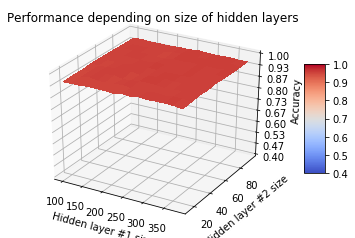

max:

((360, 85), 0.96499999999999997)

done after

4380.85780954361

running nn_opt_layers-batch

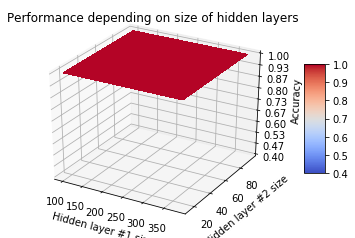

max:

((140, 85), 1.0)

done after

5571.124893903732

running nn_opt_layers-full_pca

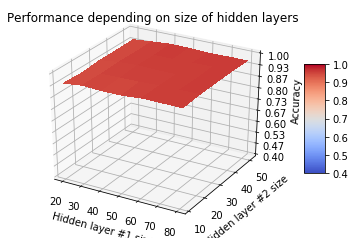

max:

((80, 41), 0.96699999999999997)

done after

207.56256103515625

running nn_opt_layers-batch_pca

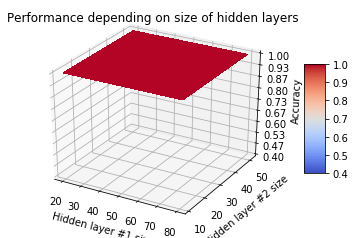

max:

((70, 51), 1.0)

done after

270.2452747821808

omg, the end. total time=

10429.81305193901

In [37]:
import time

start = time.time()

print("running nn_opt_layers-full")
run_full_nn_experiment("nn_opt_layers-full", pca=False, full_data=True)
print("done after", time.time()-start)
checkpoint = time.time()

print("running nn_opt_layers-batch")
run_full_nn_experiment("nn_opt_layers-batch", pca=False, full_data=False)
print("done after", time.time()-checkpoint)
checkpoint = time.time()

print("running nn_opt_layers-full_pca")
run_full_nn_experiment("nn_opt_layers-full_pca", pca=True, full_data=True)
print("done after", time.time()-checkpoint)
checkpoint = time.time()

print("running nn_opt_layers-batch_pca")
run_full_nn_experiment("nn_opt_layers-batch_pca", pca=True, full_data=False)
print("done after", time.time()-checkpoint)
checkpoint = time.time()

end = time.time()

print("omg, the end. total time=", end-start)

In [23]:
print("running nn_opt_layers-batch_pca")
checkpoint = time.time()
run_full_nn_experiment("nn_opt_layers-batch_pca", pca=True, full_data=False)
print("done after", time.time()-checkpoint)
checkpoint = time.time()

running nn_opt_layers-batch_pca

ValueError: Unknown projection '3d'

In [32]:
X, Y, Z, total_results = tune_layer_size(pca=True, full_data=False)

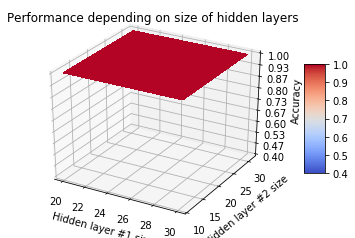

In [33]:
name = "test"
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')


# print(X.shape)
# print(Y.shape)
X, Y = np.meshgrid(X, Y)
# print(Z.shape)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       vmin=0.4, vmax=1)

# Customize the z axis.
ax.set_zlim(0.4, 1)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Customize descriptions
ax.set_xlabel('Hidden layer #1 size')
ax.set_ylabel('Hidden layer #2 size')
ax.set_zlabel('Accuracy')
plt.title("Performance depending on size of hidden layers")

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
if name:
    plt.savefig("experiment-results/" + name + ".png", dpi=400)
plt.show()